# Libraries

In [2]:
# standard
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, date
from collections import defaultdict, Counter
import json
from concurrent.futures import ThreadPoolExecutor, as_completed

# machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# graphs
import matplotlib.pyplot as plt
import seaborn as sns

# read in data

In [3]:
market_cap_df = pd.read_csv('../data/market_cap.csv').T
# rename columns
market_cap_df.columns = market_cap_df.loc['Quarter']
# Drop the 'Quarter' row
market_cap_df.drop('Quarter', inplace=True)

# Analysis

### descriptive

In [4]:
# Function to classify companies based on market cap
def classify_market_cap(market_cap):
    if market_cap < 300000000:
        return 'Micro-Cap'
    elif 300000000 <= market_cap < 2000000000:
        return 'Small-Cap'
    elif 2000000000 <= market_cap < 10000000000:
        return 'Mid-Cap'
    elif 10000000000 <= market_cap < 200000000000:
        return 'Large-Cap'

# Function to find the first non-NaN market cap in each column and classify
def classify_first_valid_market_cap(column):
    first_valid_index = column.first_valid_index()
    if first_valid_index is not None:
        return classify_market_cap(column[first_valid_index])
    return None  # or some default value if no valid market cap is found

# Apply the function to each column
market_cap_df['market_cap'] = market_cap_df.apply(classify_first_valid_market_cap, axis=1)

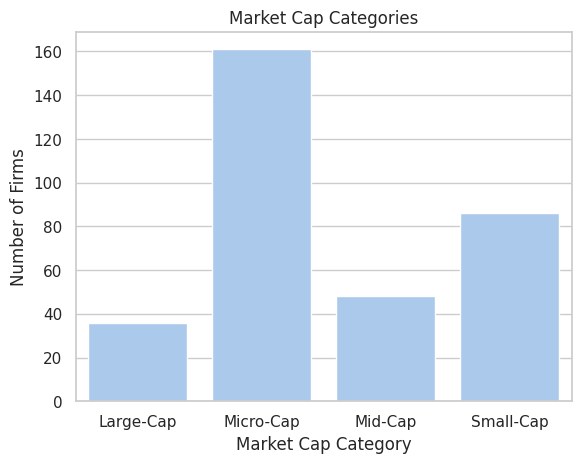

In [5]:
def count_firms_by_category(classification_series):
    return classification_series.value_counts().sort_index()

def plot_firm_categories(title):
    # Combine the two Series into a DataFrame
    combined_df = pd.DataFrame({
        'First_Quarter': count_firms_by_category(market_cap_df['market_cap'])
    }).fillna(0)  # Fill NaNs with 0
        
    # Set the style and palette
    sns.set(style="whitegrid")
    sns.set_palette("pastel")
    
    # Create the barplot
    sns.barplot(x='market_cap', y='First_Quarter', data=combined_df)
    
    # Add labels and title
    plt.title(title)
    plt.xlabel('Market Cap Category')
    plt.ylabel('Number of Firms')
    
    # Show the plot
    plt.savefig(f"../graphs/{title}.png")
    plt.show()

# Usage Example
plot_firm_categories('Market Cap Categories')


### Clustering

##### relative price changes

stock splits are being interpolated linearly, since they would otherwise be seen as outliers

In [6]:
# Reverse the DataFrame order
reversed_df = market_cap_df.iloc[:, :-1]

# Calculate the percentage change
relative_changes_df = reversed_df.pct_change(axis=1)

# The first column will now have NaN values because there is no previous timestamp to compare to
# You may want to drop it or fill it with zeros
relative_changes_df = relative_changes_df.fillna(0)

# print 5 largest values in data frame
print(f"5 largest relative changes per quarter: \n {relative_changes_df.unstack().nlargest(5)}")

# Define a function to detect outliers
def detect_outliers(df, std_dev_factor=3):
    outlier_mask = df.apply(lambda x: (x + x.mean()) > (std_dev_factor * x.std()), axis=0)
    return outlier_mask

# Detect outliers in the entire DataFrame
outlier_mask = detect_outliers(relative_changes_df)

# Replace outliers with NaN
relative_changes_df[outlier_mask] = np.nan

# Interpolate the NaN values linearly across each column
relative_changes_df.interpolate(method='linear', limit_direction='both', axis=0, inplace=True)

kde_df = relative_changes_df

5 largest relative changes per quarter: 
 Quarter         
2017-12-31  ACT     62.815196
2016-06-30  SNG     23.622285
2015-03-31  WCMK    10.661519
2015-09-30  EMH     10.485636
2018-12-31  TTO      9.196240
dtype: float64


/tmp/ipykernel_446/1580694796.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  relative_changes_df = reversed_df.pct_change(axis=1)


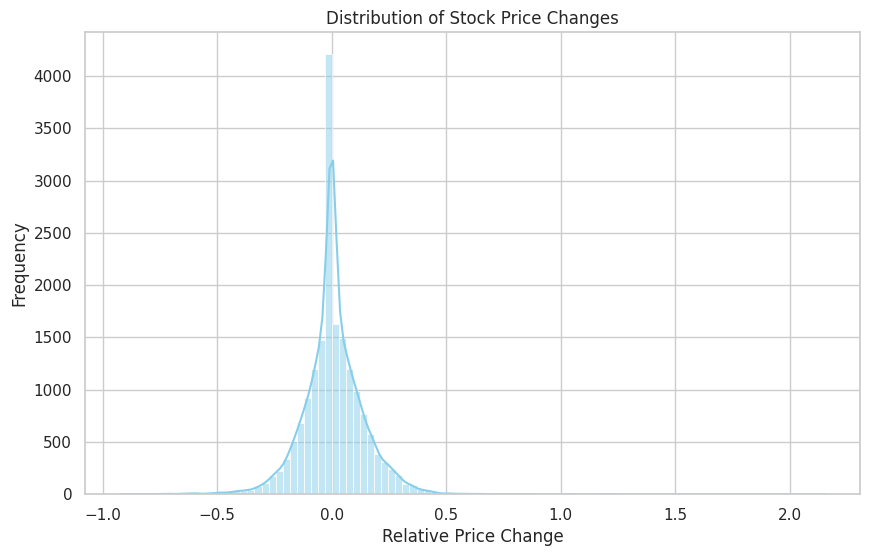

In [7]:
# Set the first column as the index (stock tickers)
kde_df = kde_df.set_index(kde_df.columns[0])

# Melt the DataFrame to long format
df_long = kde_df.melt(ignore_index=False, var_name='Date', value_name='PriceChange').reset_index()

# Rename the index column to 'Stock'
df_long.rename(columns={df_long.columns[0]: 'Stock'}, inplace=True)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df_long['PriceChange'], kde=True, bins=100, color='skyblue')

# Set labels and title
title = 'Distribution of Stock Price Changes'
plt.title(f"{title}")
plt.xlabel('Relative Price Change')
plt.ylabel('Frequency')

# Show the plot
plt.savefig(f"../graphs/{title}.png")
plt.show()

del kde_df, df_long

##### best k

Calculating Best k: 100%|██████████| 9/9 [00:00<00:00, 19.99it/s]

Silhouette score for k=2: 0.059170343391445675
Silhouette score for k=4: 0.02708661475431124
Silhouette score for k=3: 0.04110932040558097
Silhouette score for k=5: 0.04302278288627707
Silhouette score for k=10: 0.022895543858802877
Silhouette score for k=7: 0.01833571145572753
Silhouette score for k=6: 0.008947693452263308
Silhouette score for k=8: 0.010014278986012651
Silhouette score for k=9: 0.02407004614750464


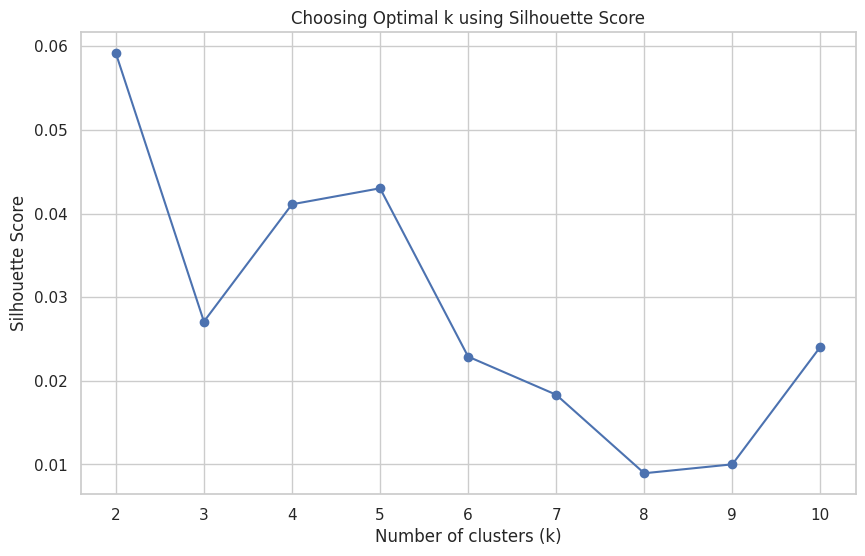

In [8]:
def calculate_silhouette(k, df_scaled):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_scaled, labels)
    return silhouette_avg

def best_k(data, highest_k):
    df = data.fillna(0)
    
    # Standardize the columns
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    # Initialize list to store silhouette_scores
    silhouette_scores = []
    
    k_values = range(2, highest_k)
    
    # Use ThreadPoolExecutor to parallelize the calculation
    with ThreadPoolExecutor() as executor:
        future_to_k = {executor.submit(calculate_silhouette, k, df_scaled): k for k in k_values}
        for future in tqdm(as_completed(future_to_k), total=len(k_values), desc='Calculating Best k'):
            k = future_to_k[future]
            try:
                silhouette_score = future.result()
                silhouette_scores.append(silhouette_score)
                print(f"Silhouette score for k={k}: {silhouette_score}")
            except Exception as exc:
                print(f'Generated an exception for k={k}: {exc}')
    
    # Check if silhouette_scores is empty
    if not silhouette_scores:
        print("No silhouette scores were calculated. Please check the exceptions above.")
        return
    
    # Plot the silhouette_scores against k_values
    title = 'Choosing Optimal k using Silhouette Score'
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f"{title}")
    plt.savefig(f"../graphs/{title}.png")
    plt.show()

# Call the function with the DataFrame excluding the last column
best_k(relative_changes_df, 11)


##### cluster graph

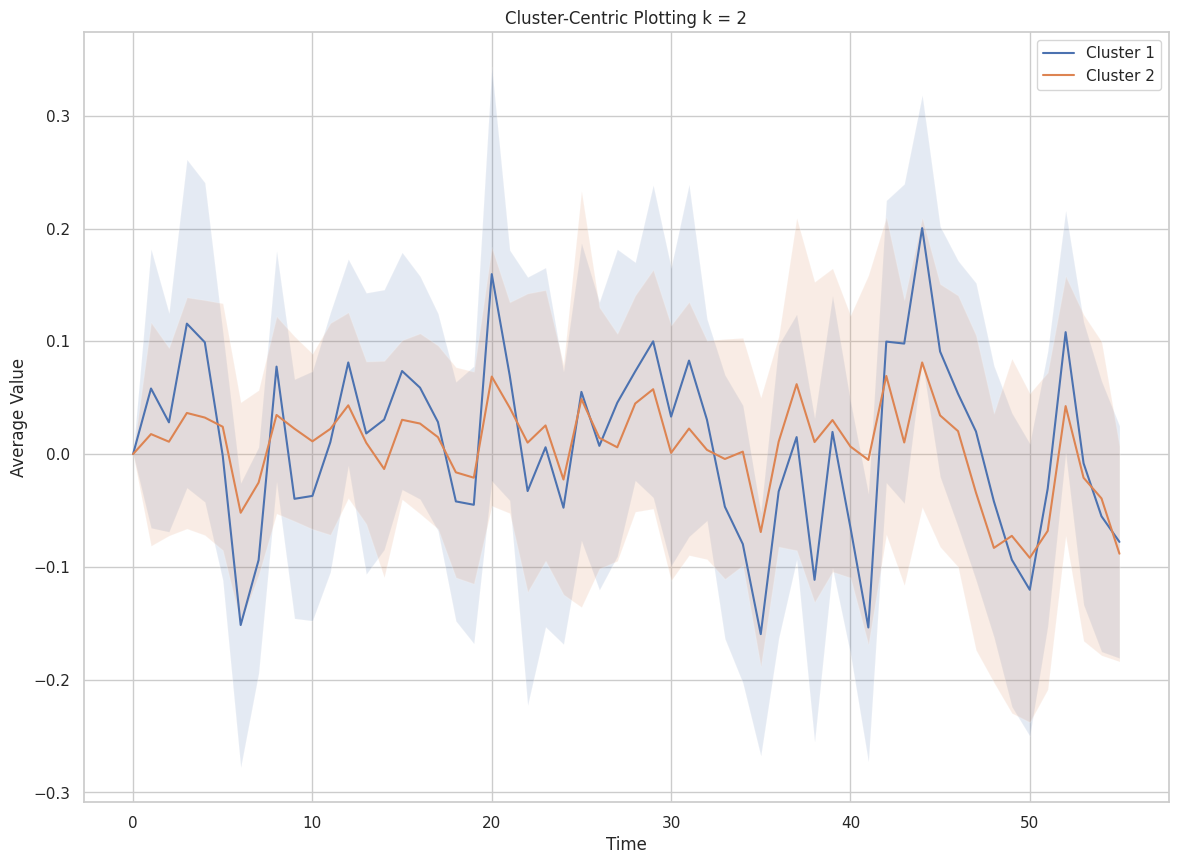

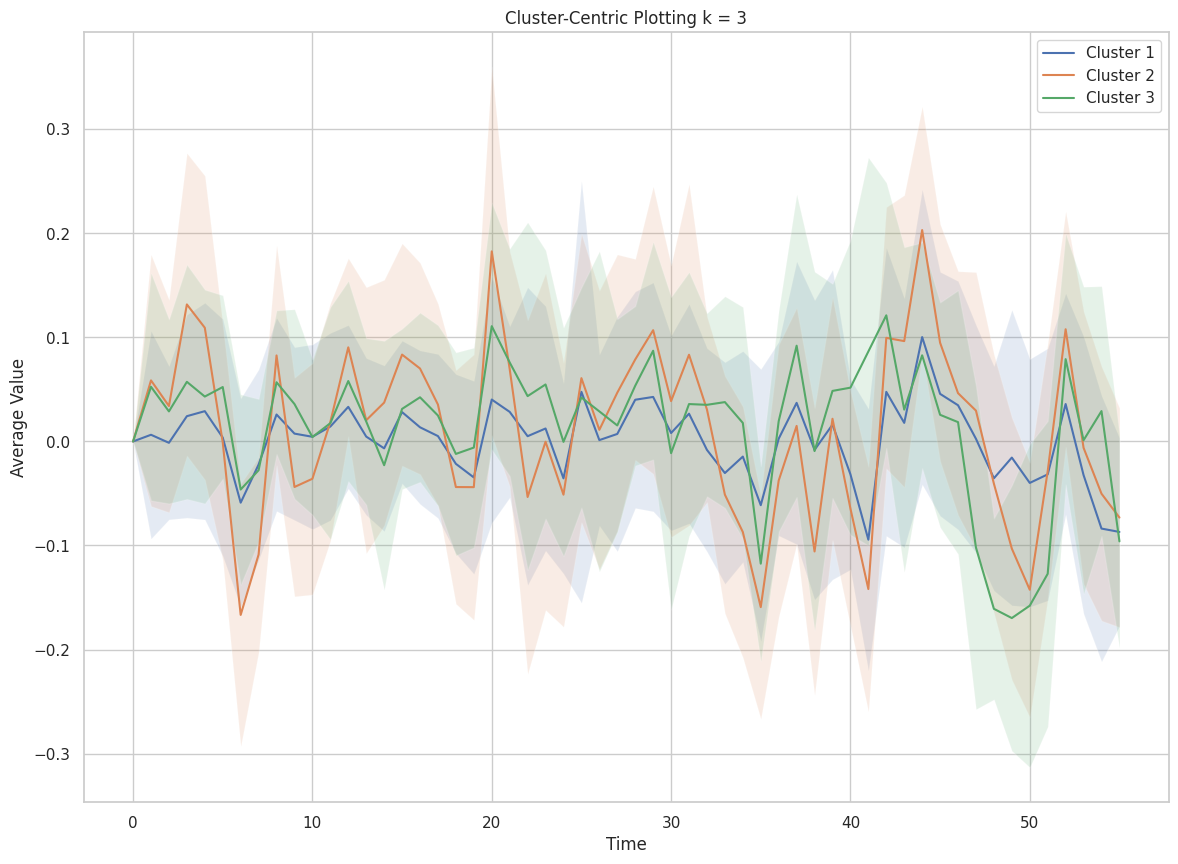

In [9]:
def cluster_centric_plotting(data, best_k):
    df = data.fillna(0).copy()  # Create a copy to work with
    df.columns = range(0,df.shape[1])

    # Perform clustering
    kmeans = KMeans(n_clusters=best_k, n_init=10)
    kmeans.fit(df)
    labels = kmeans.labels_
    
    # Add cluster labels to the dataframe
    df['Cluster'] = labels
    # Initialize the plot
    plt.figure(figsize=(14, 10))
    
    # Plot the average time series for each cluster
    for i in range(best_k):
        cluster_data = df[df['Cluster'] == i].drop(['Cluster'], axis=1)
        
        # Calculate the average time series for this cluster
        cluster_average = cluster_data.mean(axis=0)
        
        # Calculate the standard deviation for this cluster
        cluster_std = cluster_data.std(axis=0)
        
        # Convert to numpy arrays and remove NaNs and infs
        x_values = np.array(cluster_average.index, dtype=float)
        y_values = np.array(cluster_average.values, dtype=float)
        y_values_std = np.array(cluster_std.values, dtype=float)
        
        x_values = x_values[np.isfinite(y_values)]
        y_values_std = y_values_std[np.isfinite(y_values)]
        y_values = y_values[np.isfinite(y_values)]

        # Plot the average time series
        plt.plot(x_values, y_values, label=f'Cluster {i+1}')
        
        # Plot the shaded region for standard deviation
        plt.fill_between(x_values,
                         y_values - y_values_std,
                         y_values + y_values_std,
                         alpha=0.15)
    
    title_str = f'Cluster-Centric Plotting k = {best_k}'
    plt.title(f"{title_str}")
    plt.xlabel('Time')
    plt.ylabel('Average Value')
    plt.legend()
    plt.savefig(f"../graphs/{title_str}.png")
    plt.show()


k_list = [2, 3]

for k in k_list:
    cluster_centric_plotting(relative_changes_df, k)

##### Cluster Analysis

In [10]:
def clustering(data, target_df, k):
    # Perform clustering
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data)
    labels = kmeans.labels_
    target_df['Cluster'] = labels

    return target_df

market_cap_df = clustering(relative_changes_df, market_cap_df, 3)

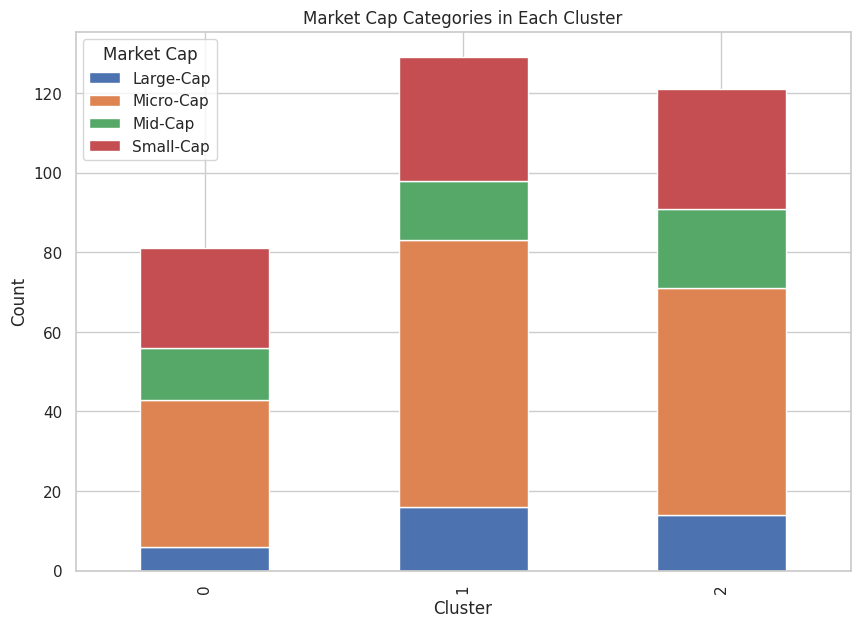

In [11]:
# Group by 'Cluster' and 'market_cap_start' and count the occurrences
cluster_market_cap_counts = market_cap_df.groupby(['Cluster', 'market_cap']).size().reset_index(name='Count')

# Pivot the DataFrame to get market cap categories as columns
pivot_df = cluster_market_cap_counts.pivot(index='Cluster', columns='market_cap', values='Count')

# Plot a stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))

title = "Market Cap Categories in Each Cluster"
plt.title(f'{title}')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Market Cap')
plt.savefig(f"../graphs/{title}.png")
plt.show()


# size effect

In [18]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    # Calculate the excess returns
    excess_returns = returns - risk_free_rate
    # Calculate the average of the excess returns
    average_excess_return = np.mean(excess_returns)
    # Calculate the standard deviation of the excess returns
    std_dev_excess_return = np.std(excess_returns)
    # Calculate the Sharpe Ratio
    sharpe_ratio = average_excess_return / std_dev_excess_return
    return sharpe_ratio

def size_effect(data, growth_threshold, risk_free_rate):
    # Check if 'market_cap' column exists
    if 'market_cap' not in data.columns:
        raise KeyError("The DataFrame does not contain a 'market_cap' column.")
        
    # Step 1: Filter for Large-Cap companies
    large_caps = data[data['market_cap'] == 'Large-Cap']
    large_caps_growth = large_caps.drop(columns=['market_cap']).mean(axis=0)

    # Step 2: Identify extreme growth periods for Large-Cap companies
        # Growth
    extreme_growth_periods = large_caps_growth > growth_threshold
    extreme_growth_quarters = extreme_growth_periods[extreme_growth_periods].index
        # Loss
    extreme_loss_periods = large_caps_growth < (growth_threshold * -1)
    extreme_loss_quarters = extreme_loss_periods[extreme_loss_periods].index

    # Step 3: Extract the same periods for Small-Cap companies
    small_caps = data[data['market_cap'].isin(['Small-Cap', 'Micro-Cap'])]
    small_caps_growth = small_caps.loc[:, extreme_growth_quarters]
    small_caps_loss = small_caps.loc[:, extreme_loss_quarters]

    # Step 4: Calculate average performance for Small-Cap companies
    average_performance = small_caps_growth.mean(axis=0)
    average_loss = small_caps_loss.mean(axis=0)

    # Step 5: Determine how many Small-Cap companies exceeded the Large-Cap growth
    # Align the large_caps_growth Series with the small_caps_growth DataFrame along the columns
    exceeded_growth = (average_performance > large_caps_growth[extreme_growth_periods]).sum(axis=0)
    under_growth = (average_performance < large_caps_growth[extreme_growth_periods]).sum(axis=0)

    minimized_loss = (average_loss < large_caps_growth[extreme_loss_periods]).sum(axis=0)
    worse_loss = (average_loss > large_caps_growth[extreme_loss_periods]).sum(axis=0)

    print(f"Extreme growth periods: {extreme_growth_periods.sum(axis=0)} {extreme_growth_quarters.tolist()}")
    print(f"Number of times measurable size effect: {exceeded_growth}")
    print(f"Number of times absent size effect: {under_growth}")

    print(f"Extreme loss periods: {extreme_loss_periods.sum(axis=0)} {extreme_loss_quarters.tolist()}")
    print(f"Number of times size effect reduces loss: {minimized_loss}")
    print(f"Number of times size effect worsenes loss: {worse_loss}")

    # Calculate Sharpe Ratios
    large_caps_growth_periods = large_caps[extreme_growth_quarters]
    large_caps_loss_periods = large_caps[extreme_loss_quarters]
    small_caps_growth_periods = small_caps[extreme_growth_quarters]
    small_caps_loss_periods = small_caps[extreme_loss_quarters]

    sharpe_ratios_large_caps_growth = large_caps_growth_periods.apply(lambda x: calculate_sharpe_ratio(x, risk_free_rate))
    sharpe_ratios_small_caps_growth = small_caps_growth_periods.apply(lambda x: calculate_sharpe_ratio(x, risk_free_rate))
    sharpe_ratios_large_caps_loss = large_caps_loss_periods.apply(lambda x: calculate_sharpe_ratio(x, risk_free_rate))
    sharpe_ratios_small_caps_loss = small_caps_loss_periods.apply(lambda x: calculate_sharpe_ratio(x, risk_free_rate))

    # Print Sharpe Ratios
    print("\nSharpe Ratios during Growth Periods:")
    print("Large-Caps:", sharpe_ratios_large_caps_growth)
    print("Small-Caps:", sharpe_ratios_small_caps_growth)

    print("\nSharpe Ratios during Loss Periods:")
    print("Large-Caps:", sharpe_ratios_large_caps_loss)
    print("Small-Caps:", sharpe_ratios_small_caps_loss)

relative_changes_df['market_cap'] = market_cap_df['market_cap']
size_effect(relative_changes_df, growth_threshold=0.1, risk_free_rate=0.04)

Extreme growth periods: 4 ['2015-03-31', '2020-09-30', '2021-03-31', '2023-03-31']
Number of times measurable size effect: 1
Number of times absent size effect: 3
Extreme loss periods: 1 ['2022-09-30']
Number of times size effect reduces loss: 0
Number of times size effect worsenes loss: 1

Sharpe Ratios during Growth Periods:
Large-Caps: Quarter
2015-03-31    0.906965
2020-09-30    0.622988
2021-03-31    0.589292
2023-03-31    0.631511
dtype: float64
Small-Caps: Quarter
2015-03-31    0.393186
2020-09-30    0.253919
2021-03-31    0.743434
2023-03-31    0.189702
dtype: float64

Sharpe Ratios during Loss Periods:
Large-Caps: Quarter
2022-09-30   -1.13676
dtype: float64
Small-Caps: Quarter
2022-09-30   -1.030678
dtype: float64


# Metrics

### Sharpe Ratio

In [13]:
relative_changes_df.head()

Quarter,2010-03-31,2010-06-30,2010-09-30,2010-12-31,2011-03-31,2011-06-30,2011-09-30,2011-12-31,2012-03-31,2012-06-30,...,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,market_cap
DRI,0.0,0.024949,-0.038921,0.171704,0.147622,0.162131,-0.009939,-0.098245,0.121873,0.111654,...,-0.012860,-0.117232,-0.132182,-0.162715,-0.206494,-0.078351,-0.144107,0.217088,0.286864,Small-Cap
TGT,0.0,-0.111688,-0.198256,-0.020739,0.131799,0.093737,-0.272334,-0.087519,-0.010933,0.083148,...,0.078638,-0.034119,-0.136513,-0.145095,-0.085846,-0.024139,-0.012141,-0.155205,-0.050054,Micro-Cap
UUU,0.0,-0.101091,0.059553,0.010082,-0.076550,0.190100,0.041481,-0.065055,-0.078516,0.025403,...,0.220471,-0.251804,-0.242955,0.215640,0.418495,0.084899,-0.122824,-0.381160,-0.021214,Micro-Cap
ACWN,0.0,0.097177,-0.015802,0.023048,-0.054486,0.003324,-0.092081,-0.191002,0.156537,0.054954,...,-0.218242,-0.137748,-0.080781,-0.193790,-0.177066,0.057767,0.076410,-0.016458,-0.094450,Micro-Cap
A4Y,0.0,0.110637,-0.034416,0.026491,0.000162,0.075258,0.078941,-0.149660,0.087810,-0.016044,...,-0.103483,-0.145178,-0.222249,-0.193899,-0.346136,-0.099512,-0.254102,0.079485,-0.149199,Micro-Cap


In [13]:
relative_changes_df.to_csv('../data/relative_pricechanges.csv')

# Test Area

In [17]:
import numpy as np
import pandas as pd

def calculate_sharpe_ratio(returns, risk_free_rate):
    # Calculate the excess returns
    excess_returns = returns - risk_free_rate
    # Calculate the average of the excess returns
    average_excess_return = np.mean(excess_returns)
    # Calculate the standard deviation of the excess returns
    std_dev_excess_return = np.std(excess_returns)
    # Calculate the Sharpe Ratio
    sharpe_ratio = average_excess_return / std_dev_excess_return
    return sharpe_ratio

def size_effect(data, growth_threshold, risk_free_rate):
    # Check if 'market_cap' column exists
    if 'market_cap' not in data.columns:
        raise KeyError("The DataFrame does not contain a 'market_cap' column.")
        
    # Filter for Large-Cap and Small-Cap companies
    large_caps = data[data['market_cap'] == 'Large-Cap']
    small_caps = data[data['market_cap'].isin(['Small-Cap', 'Micro-Cap'])]

    # Calculate average growth for Large-Cap companies
    large_caps_growth = large_caps.drop(columns=['market_cap']).mean(axis=0)

    # Identify extreme growth and loss periods for Large-Cap companies
    extreme_growth_periods = large_caps_growth > growth_threshold
    extreme_loss_periods = large_caps_growth < (growth_threshold * -1)

    # Convert boolean Series to lists of columns
    extreme_growth_quarters = extreme_growth_periods[extreme_growth_periods].index.tolist()
    extreme_loss_quarters = extreme_loss_periods[extreme_loss_periods].index.tolist()

    # Extract relevant periods for Sharpe Ratio calculation
    large_caps_growth_periods = large_caps[extreme_growth_quarters]
    large_caps_loss_periods = large_caps[extreme_loss_quarters]
    small_caps_growth_periods = small_caps[extreme_growth_quarters]
    small_caps_loss_periods = small_caps[extreme_loss_quarters]

    # Calculate Sharpe Ratios
    sharpe_ratios_large_caps_growth = large_caps_growth_periods.apply(lambda x: calculate_sharpe_ratio(x, risk_free_rate))
    sharpe_ratios_small_caps_growth = small_caps_growth_periods.apply(lambda x: calculate_sharpe_ratio(x, risk_free_rate))
    sharpe_ratios_large_caps_loss = large_caps_loss_periods.apply(lambda x: calculate_sharpe_ratio(x, risk_free_rate))
    sharpe_ratios_small_caps_loss = small_caps_loss_periods.apply(lambda x: calculate_sharpe_ratio(x, risk_free_rate))

    # Print Sharpe Ratios
    print("\nSharpe Ratios during Growth Periods:")
    print("Large-Caps:", sharpe_ratios_large_caps_growth)
    print("Small-Caps:", sharpe_ratios_small_caps_growth)

    print("\nSharpe Ratios during Loss Periods:")
    print("Large-Caps:", sharpe_ratios_large_caps_loss)
    print("Small-Caps:", sharpe_ratios_small_caps_loss)

# Assuming relative_changes_df, market_cap_df, and risk_free_rate are defined
size_effect(relative_changes_df, 0.1, risk_free_rate=0.04)



Sharpe Ratios during Growth Periods:
Large-Caps: Quarter
2015-03-31    0.906965
2020-09-30    0.622988
2021-03-31    0.589292
2023-03-31    0.631511
dtype: float64
Small-Caps: Quarter
2015-03-31    0.393186
2020-09-30    0.253919
2021-03-31    0.743434
2023-03-31    0.189702
dtype: float64

Sharpe Ratios during Loss Periods:
Large-Caps: Quarter
2022-09-30   -1.13676
dtype: float64
Small-Caps: Quarter
2022-09-30   -1.030678
dtype: float64
